In [1]:
# Import Libraries 
%matplotlib inline
import os
import argparse
import matplotlib
import cv2
import numpy as np
import networkx as nx
import sknetwork as sknw
import skimage.graph
import imutils

from plantcv import plantcv as pcv

In [2]:
class options:
    def __init__(self):
        self.image = "/data/2022_root_robot/trial_seedlings/Input/simple_test_color.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "/data/2022_root_robot/trial_seedlings/Output/" # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

In [3]:
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

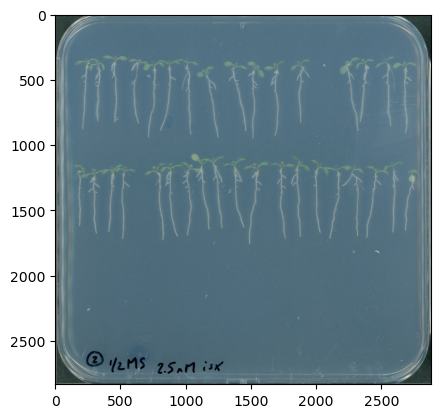

In [4]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img_full, path, filename = pcv.readimage(filename=args.image)

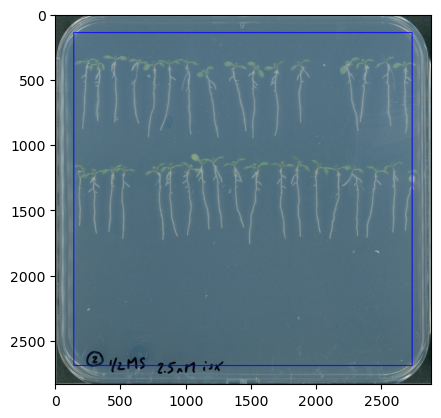

In [5]:
# Crop image
roi_y = int(round(img_full.shape[0] * 0.05))
roi_x = int(round(img_full.shape[1] * 0.05))
roi_h = int(round(img_full.shape[0] - (img_full.shape[0] * 0.1)))
roi_w = int(round(img_full.shape[1] - (img_full.shape[1] * 0.1)))


img = pcv.crop(img=img_full, x=roi_x, y=roi_y, h=roi_h, w=roi_w)

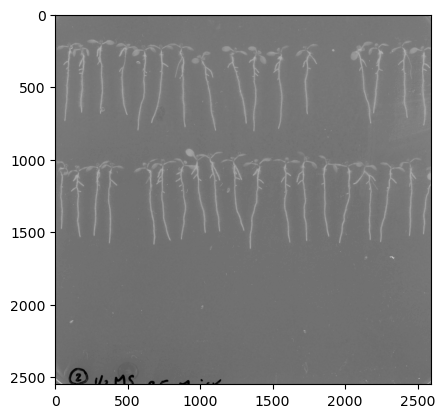

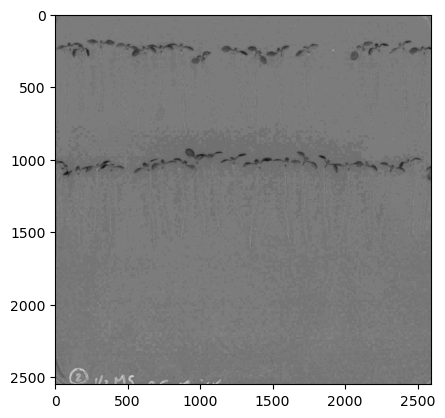

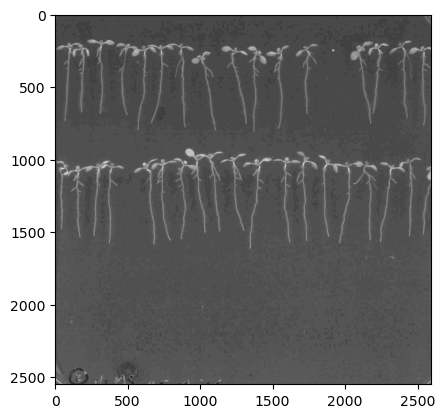

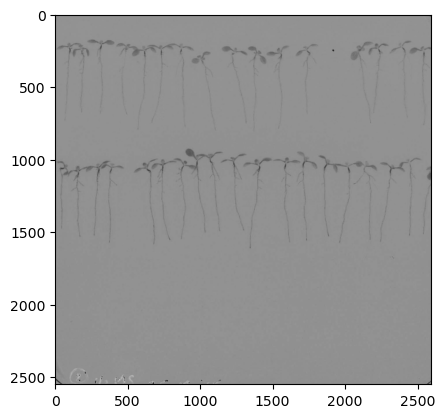

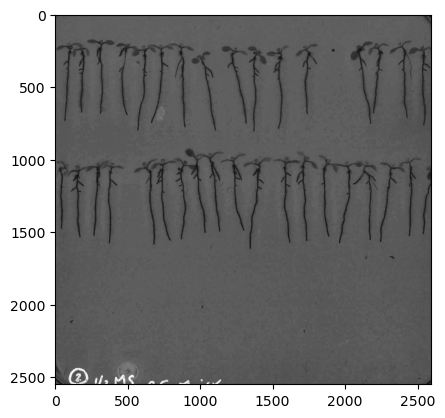

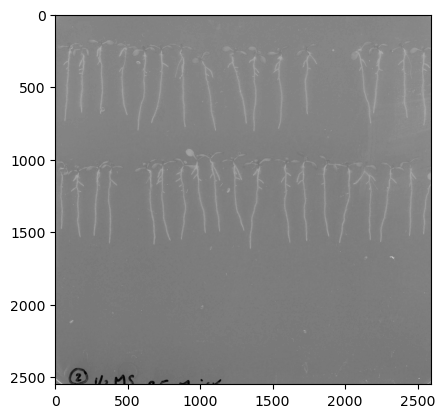

In [6]:
l = pcv.rgb2gray_lab(img, "l")
a = pcv.rgb2gray_lab(img, "a")
b = pcv.rgb2gray_lab(img, "b")

h = pcv.rgb2gray_hsv(img, "h")
s = pcv.rgb2gray_hsv(img, "s")
v = pcv.rgb2gray_hsv(img, "v")

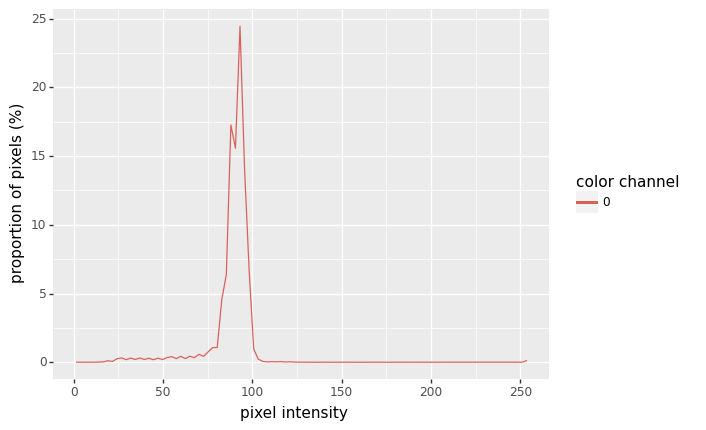

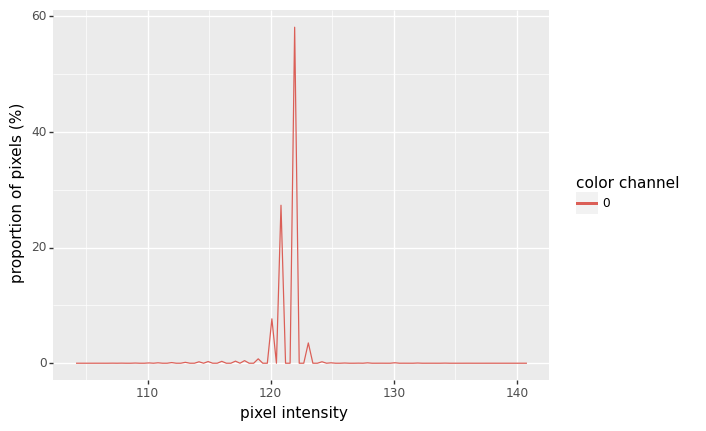

In [7]:
hist = pcv.visualize.histogram(img=s)
hist = pcv.visualize.histogram(img=a)

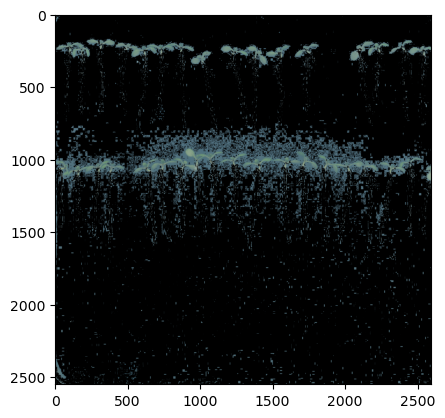

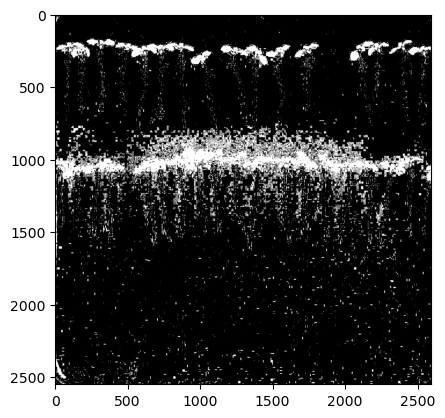

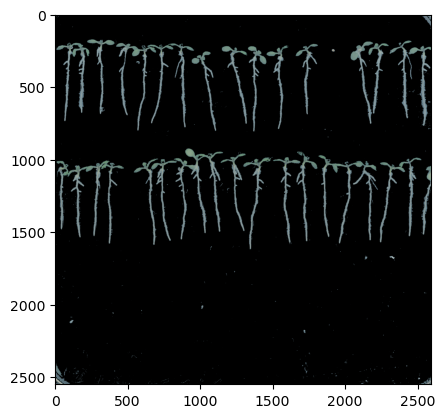

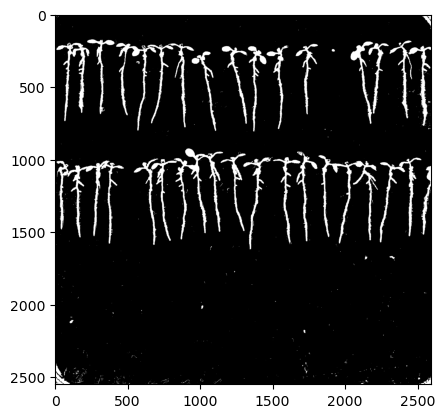

In [8]:
# mask leaves
leaves, leaves_masked = pcv.threshold.custom_range(img=img, lower_thresh=[0,0,0], upper_thresh=[255,120,255], channel='LAB')
pcv.print_image(leaves_masked, "leaves.png")

# mask whole plant
plant, plant_masked = pcv.threshold.custom_range(img=img, lower_thresh=[0,0,0], upper_thresh=[255,75,255], channel='HSV')
pcv.print_image(plant_masked, "plant.png")

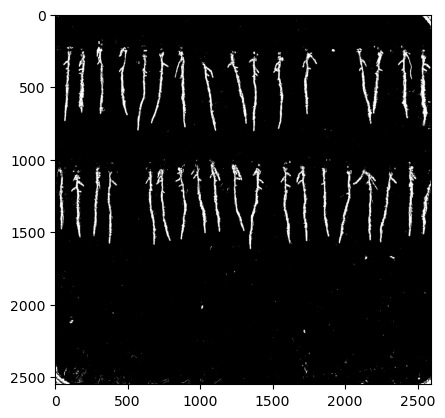

In [9]:
# subtract leaves from plant
root_raw = pcv.image_subtract(plant, leaves)

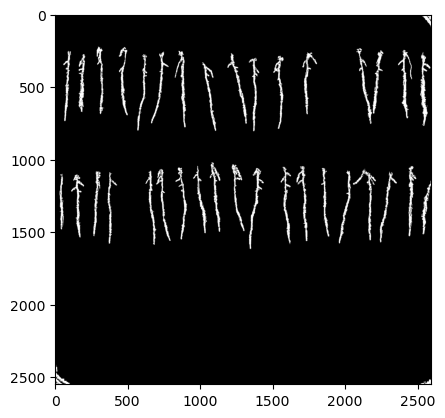

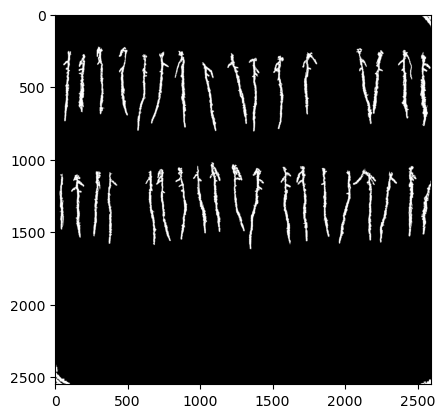

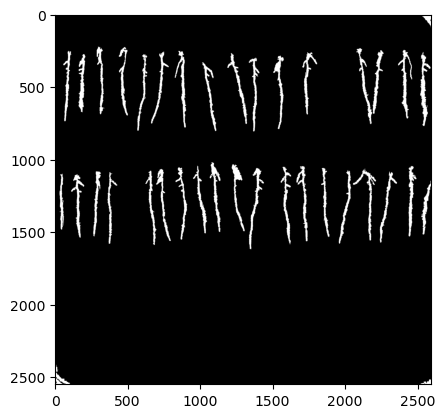

In [10]:
root_clean = pcv.fill(root_raw, 500)
root_dilated = pcv.dilate(root_clean, 2, 1)
root = pcv.fill_holes(root_dilated)

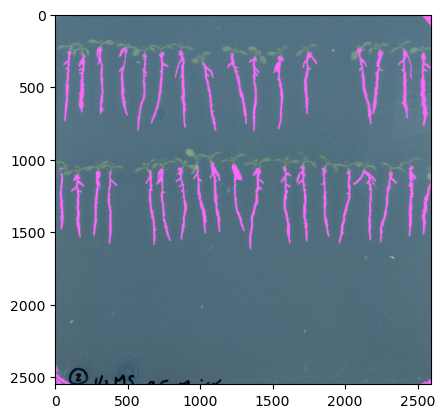

In [11]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=root)

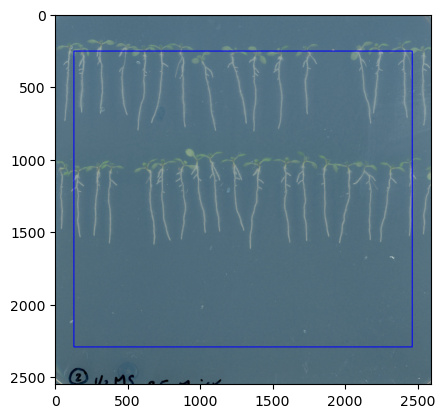

In [12]:
# Define the ROI as a rectangle relative to image size, covering 80% of the width and 60% of the height
roi_y = int(round(img.shape[0] * 0.1))
roi_x = int(round(img.shape[1] * 0.05))
roi_h = int(round(img.shape[0] - (img.shape[0] * 0.2)))
roi_w = int(round(img.shape[1] - (img.shape[1] * 0.1)))
roi_contour, roi_hierarchy = pcv.roi.rectangle(img, x = roi_x, y = roi_y, h = roi_h, w = roi_w)

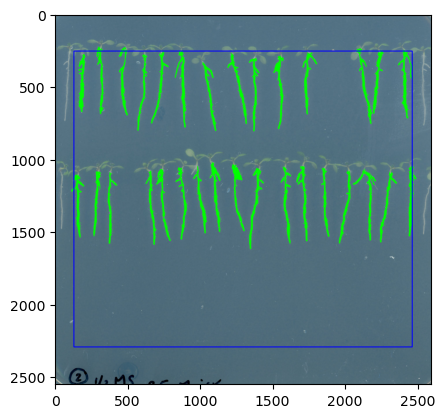

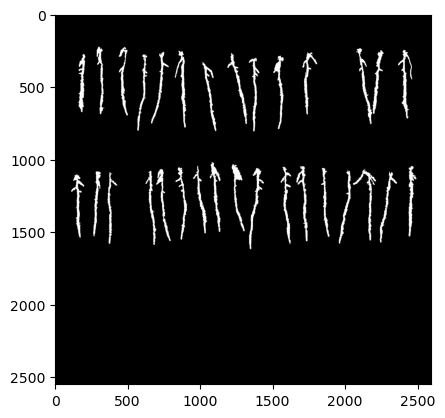

In [13]:
# cell 11
# Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img = img, 
                                                                      roi_type = 'partial', 
                                                                      roi_contour = roi_contour,
                                                                      roi_hierarchy = roi_hierarchy, 
                                                                      object_contour = id_objects, 
                                                                      obj_hierarchy = obj_hierarchy)
pcv.print_image(kept_mask, "mask.png")

There were 0 objects not annotated.


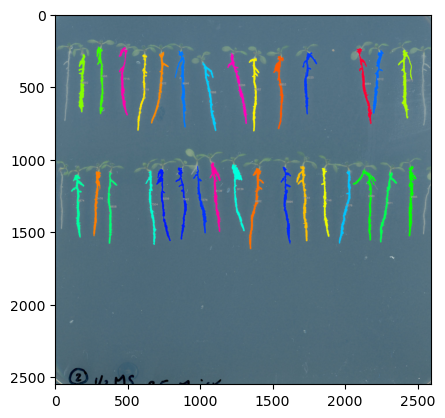

31

In [14]:
plotting_img = pcv.visualize.obj_sizes(img=img, mask=kept_mask, num_objects=150)
pcv.print_image(plotting_img, "objects.png")
len(roi_objects)

In [15]:
#seedling, seedling_mask = pcv.object_composition(img=img, contours=[roi_objects[1]], hierarchy=np.array([[roi_obj_hierarchy[0][1]]]))
#skeleton = pcv.morphology.skeletonize(mask=seedling_mask)
#skeleton = pcv.dilate(skeleton, 2, 1)

In [16]:
#seedling_contour, seedling_hierarchy = pcv.find_objects(img=img, mask=skeleton)

In [17]:
#seedling_contour = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#c = imutils.grab_contours(seedling_contour)
#hyp = tuple(c[0][c[0][:,:, 1].argmin()][0])
#tip = tuple(c[0][c[0][:,:, 1].argmax()][0])

#extreme_points_1 = cv2.circle(skeleton.copy(), tip, 5, (255,255,255), -1)
#extreme_points = cv2.circle(extreme_points_1.copy(), hyp, 5, (255,255,255), -1)
#pcv.print_image(extreme_points, "endpoints.png")

In [18]:
#primary_root, cost = shortest_path(tip[::-1], hyp[::-1], skeleton)
#primary_root_array = np.flip(np.array(primary_root))
#primary_root_array = primary_root_array.reshape((-1, 1, 2))
#img_w_root = cv2.polylines(img.copy(),primary_root_array,True,(0,255,255))
#pcv.print_image(img_w_root, "root_img.png")
#cost

In [19]:
def shortest_path(start,end,binary):
    costs = np.where(binary,1,1000)
    path, cost = skimage.graph.route_through_array(costs, start=start, end=end, fully_connected=True, geometric=True)
    return path,cost

In [20]:
# Create a copy of the RGB image for shape analysis annotations
# Inputs:
#   img = image
shape_img = np.copy(img)

# Turn off plot debugging
pcv.params.debug = None

# Interate through all objects and do a shape and color analysis
for i in range(0, len(roi_objects)):
    # Check to see if the object has an offshoot in the hierarchy
    if roi_obj_hierarchy[0][i][3] == -1:
        # Create an object and a mask for one object
        #
        # Inputs:
        #   img - rgb image
        #   contours - list entry i in objects2
        #   hierarchy - np.array of obj_hierarchy[0][1]
        seedling, seedling_mask = pcv.object_composition(img=img, contours=[roi_objects[i]], hierarchy=np.array([[roi_obj_hierarchy[0][i]]]))
        
        # Analyze shape of each seed
        #
        # Inputs:
        #   img - rgb image
        #   obj - seed
        #   mask - mask created of single seed
        #   label - label for each seed in image
        shape_img = pcv.analyze_object(img=shape_img, obj=seedling, mask=seedling_mask, label=f"seedling{i}")
        
        # Skeletonize each seedling
        skeleton_raw = pcv.morphology.skeletonize(mask=seedling_mask)
        skeleton = pcv.dilate(skeleton_raw, 3, 1)
        # Find dilated skeleton contour
        seedling_contour = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c = imutils.grab_contours(seedling_contour)
        # Find y-axis extremes (hypocotyl and root tip)
        hyp = tuple(c[0][c[0][:,:, 1].argmin()][0])
        tip = tuple(c[0][c[0][:,:, 1].argmax()][0])
        # Find shortest path from hypocotyl to root tip through the root skeleton
        primary_root, cost = shortest_path(tip[::-1], hyp[::-1], skeleton)
        primary_root_array = np.flip(np.array(primary_root))
        primary_root_array = primary_root_array.reshape((-1, 1, 2))
        root_img = cv2.polylines(img, primary_root_array, True, (0,255,255), 5)
        
        #with open(r'size_marker.csv', 'a') as f:
        #writer = csv.writer(f)
        #writer.writerow([filename, space[0]])
            

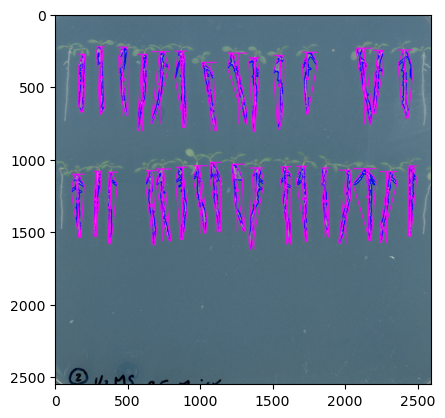

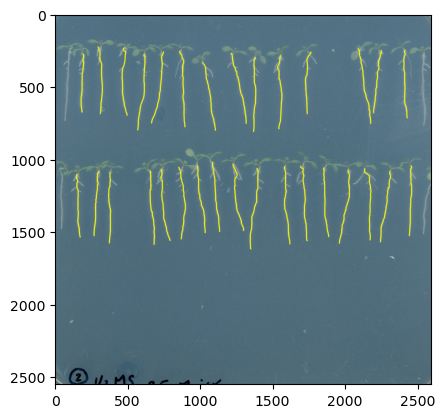

In [21]:
pcv.plot_image(img=shape_img)
pcv.print_image(shape_img, "shape_img.png")
pcv.plot_image(img=root_img)
pcv.print_image(root_img, "root_img.png")